<a href="https://colab.research.google.com/github/zyf2021/-/blob/main/wine_segmentation_v_0_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

In [ ]:
# Install segmentation models package
!pip install segmentation-models-pytorch

In [ ]:
pip install segments-ai

# Download Dataset

I will be using an open source dataset for this task which is available on GitHub. The dataset contains images of humans in different environments and settings and their corresponding masks. The masks can be thought of as the outline of the humans/objects in the image and helps to identify their positions in the image separating them from the background.

Credits for the dataset goes to [Vikram Shenoy](https://github.com/VikramShenoy97/Human-Segmentation-Dataset)

In [ ]:
from segments import SegmentsClient, SegmentsDataset
from segments.utils import export_dataset

# Initialize a SegmentsDataset from the release file
client = SegmentsClient('7d4e830aad20725decd837320b15caaae0ac1bbe')
release = client.get_release('tynshun/wineyard', 'v0.0.4') # Alternatively: release = 'flowers-v1.0.json'
dataset = SegmentsDataset(release, labelset='ground-truth', filter_by=['labeled', 'reviewed'])

# Export to COCO panoptic format
export_dataset(dataset, export_format='coco-panoptic')

# Import libraries

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Setup Configurations

In this step I would define the different paths, hyperparameters, models and weights which I will be using later in the notebook.

In [53]:
# Define path variables
TRAIN_DATA_PATH = '/content/export_coco-panoptic_tynshun_wineyard_v0.0.4.json'
DATA_DIR = '/content/segments/tynshun_wineyard/v0.0.4/'

train_dir = '/'
test_dir = '/'

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 10        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 320     # Size of image
BATCH_SIZE = 32    # Batch size

# Define pretrained encoder model and weights
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

# Load Data and Find classes
!! ты поменяла имена столбцов
функции вывода рабоать не будут


In [6]:
def get_df_images_masks(path_to_coco, path_to_dir):
  # Загрузка JSON-файла аннотаций COCO
  with open(path_to_coco, 'r') as f:
    coco_data = json.load(f)
    df_images = pd.DataFrame(coco_data['images'])
    df_images['file_name'] = df_images['file_name'].apply(lambda x: path_to_dir + x)
    df_images.rename(columns={'id': 'image_id'}, inplace=True)
    df_annotations = pd.DataFrame(coco_data['annotations'])
    df_annotations['file_name'] = df_annotations['file_name'].apply(lambda x: path_to_dir + x)
    # Склеивание DataFrame по столбцу 'id'
    merged_df = pd.merge(df_images, df_annotations, on='image_id')
    merged_df.rename(columns={'file_name_x': 'images'}, inplace=True)
    merged_df.rename(columns={'file_name_y': 'masks'}, inplace=True)
    return merged_df

In [7]:
df = get_df_images_masks(TRAIN_DATA_PATH, DATA_DIR)
df.head()
print(df.shape)

(113, 6)


## Функция по поиску классов сегментации

In [8]:
def find_classes(directory: str): # указать возвращаемый тип данных
    # дописать многострочный комментарий
    with open(directory, 'r') as f:
        data_json = json.load(f)
    type(data_json['categories'])
    classes = [cat['name'] for cat in data_json['categories']]
    classes_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, classes_idx

The dataframe consists of images and their corresponding masks. Let's see some of the sample images and masks.

# Explore the Data

In [ ]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]# выберем 5 случайных индексов из нашего df

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0 #перевод в серую шкалу и нормализация! ВАУ!

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

In [ ]:
generate_sample_images(sample)
generate_sample_masks(sample)

# Split the Data

Let's split our data into training and validation sets before training the model.

In [9]:
# Split data in separate train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

In [14]:
def show_image_from_df(image_path):
    image = cv2.imread(image_path)
  # Отображение изображения
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Data Augmentation

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Processing the Dataset

In [12]:
from PIL import Image
from torch.utils.data import Dataset

здесь я хочу переписать его следующим образом... вместо targ_dir сделать df и с ним работать также как и в v0.0.1

In [87]:
class ImageFolderCustom(Dataset):
    def __init__(self, df, targ_dir, transform=None) -> None:
        # Упростили по сравнению с прошлой версией кода
        self.df = df
        self.transform = transform
        # Попробуем создать вывод классов
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def __len__(self) -> int:
        return len(self.df)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int): # -> Tuple[torch.Tensor, int]:

        sample = self.df.iloc[index]
        image = sample.images # путь к файлу изобржания
        mask = sample.masks # путь к файлу маски

        # Чтение images and masks. МБ ФУНКЦИЕЙ  def load_image(self, index: int) -> Image.Image:
        image = Image.open(image)
        mask = Image.open(mask)
        mask = mask.convert("L")

        # Преобразовать изображение в массив NumPy
        mask_np = np.array(mask)
        # Добавить дополнительное измерение для совместимости с формой, ожидаемой моделью
        mask_np = np.expand_dims(mask_np, axis=-1)


        #image = cv2.imread(image)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        #mask = np.expand_dims(mask, axis=-1)
        if self.transform:
          image = self.transform(image)
          #mask = self.transform(mask)
          # Преобразование маски в черно-белый формат
          mask = self.transform(mask)


          #image = torch.Tensor(image) / 255.0
          mask = (torch.Tensor(mask) > 0).float()



          #mask = transforms.functional.to_tensor(mask)  # Преобразовать в тензор
          #mask = (mask > 0.5).float() * 255  # Пороговая обработка


        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)

        return image, mask # return data, label (X, y)




torch.Size([1, 360, 360])
torch.float32


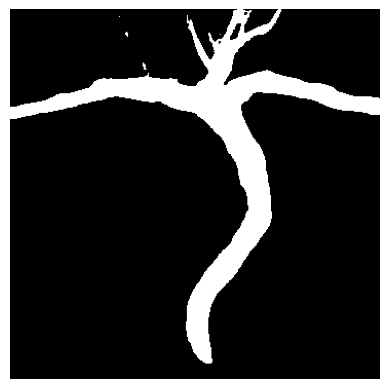

In [71]:
image_path = train_df.iloc[0]['masks']
image = Image.open(image_path)
image = image.convert("L") # Normalize the images and masks

# Преобразовать изображение в массив NumPy
image_np = np.array(image)
# Добавить дополнительное измерение для совместимости с формой, ожидаемой моделью
image_np = np.expand_dims(image_np, axis=0)

# Преобразовать в формат torch.Tensor и нормализовать
image = torch.Tensor(image_np) / 255.0

# Убедитесь, что image имеет правильную форму и тип данных
print(image.shape)  # Печатает (1, height, width)
print(image.dtype)  # Печатает torch.float32

plt.imshow(image_np[0], cmap='gray')  # Передаем нулевой индекс, так как у нас есть дополнительное измерение
plt.axis('off')  # Отключаем оси координат
plt.show()

In [ ]:
image = (torch.Tensor(image) > 0).float()
plt.imshow(image)
plt.axis('off')
plt.show()

In [88]:
train_data_custom = ImageFolderCustom(df=train_df, targ_dir=TRAIN_DATA_PATH, transform=train_transforms)
test_data_custom = ImageFolderCustom(df=val_df, targ_dir=TRAIN_DATA_PATH, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x79f4ea373e50>,
 <__main__.ImageFolderCustom at 0x79f4ea371c00>)

In [38]:
train_data_custom.classes

['wine', 'post']

In [ ]:
# Check the lengths
len(train_data_custom), len(test_data_custom)

In [ ]:
train_data_custom[0]

In [ ]:
img, label = train_data_custom[0][0], train_data_custom[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

# Display sample random images

In [19]:
import random

In [85]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    dataset = train_data_custom
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    if seed:
        random.seed(seed)

    random_array = np.random.randint(0, len(dataset), n)
    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(random_array):
        image, mask = dataset[idx]
        plt.subplot(2, 5, i+1)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.axis('off')
        plt.title("IMAGE")

        plt.subplot(2, 5, i+6)
        plt.imshow(np.transpose(mask, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title("GROUND TRUTH")
    plt.tight_layout()
    plt.show()

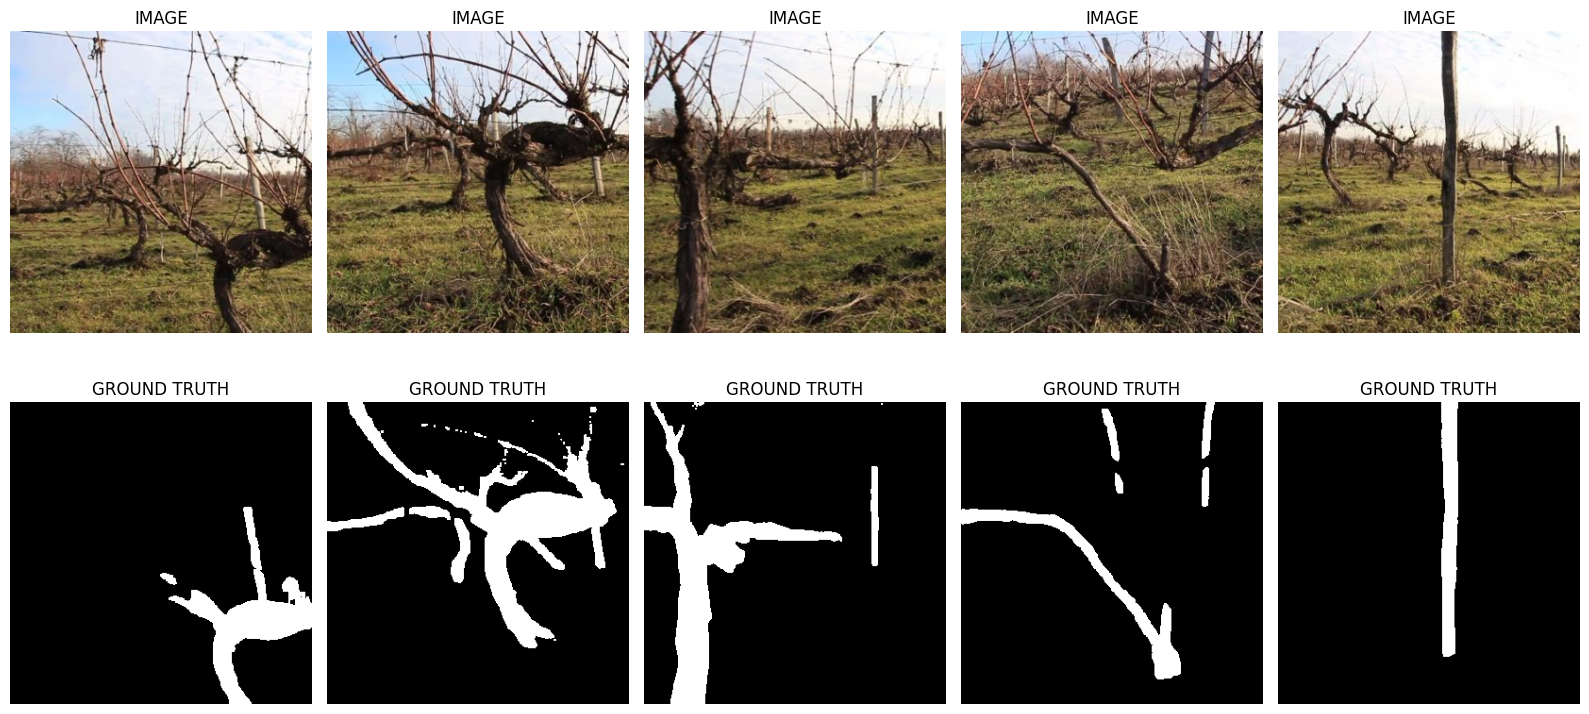

In [89]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=train_data_custom.classes,
                      seed=None)

# Load dataset into batches

In [22]:
from torch.utils.data import DataLoader

In [60]:
trainloader = DataLoader(train_data_custom, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(test_data_custom, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 3
Total number of batches in Val Loader: 1


In [61]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([32, 3, 320, 320])
Size of one batch of masks: torch.Size([32, 3, 320, 320])


# Create Segmentation Model

There are many CNN model architectures present in the pytorch's segmentation models documentation that can be used but for this project I will use Unet++ architecture. [Unet++](https://arxiv.org/abs/1807.10165) is a fully convolutional neural network for image semantic segmentation. It consists of encoder and decoder parts connected with skip connections. The encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation masks. It uses concatenation for fusing decoder blocks with skip connections.

**Documentation**: https://segmentation-models-pytorch.readthedocs.io/en/latest/models.html#id2

![UNet++ architecture](https://pic.imgdb.cn/item/60dac54e5132923bf81d4a25.jpg)

I will now create the Segmentation model using the Unet++ architecture. The parameters used for the model are:
- **Efficient Net** is used as the encoder model
- Weights used are of **Imagenet**
- Input channels are 3 due to **RGB** images

In the forward method I defined the loss functions. DiceLoss and Binary Cross Entropy are used as loss functions for this task.

[Dice loss](https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.) is a metric commonly used to evaluate the performance of machine learning models in image segmentation tasks. It is a measure of the dissimilarity between the predicted segmentation (mask) and the true segmentation of an image.

In [46]:
import gc
gc.collect()

0

In [25]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [47]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [48]:
model = SegmentationModel()
model.to(DEVICE);

The above output displays the full architecture of the UNet++. We have downloaded the model successfully. Now it's time to train it.

# Create Train and Validation Function

### Свернуть

In [49]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [50]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

Before training the model make sure that your GPU is running because it would take eternity to train the model on a CPU.

In [51]:
gc.collect()

8

### Свернуть

In [35]:
image_path = train_df.iloc[0]['masks']
image = Image.open(image_path)

input_image = train_transforms(image)

# Загружаем входное изображение на устройство
input_image = input_image.to(DEVICE).unsqueeze(0)

# Передаем изображение через модель
with torch.no_grad():
    logits = model(input_image)

print(logits.shape)

# Делаем что-то с выходом модели (например, преобразуем в изображение)
# Например, можно преобразовать в черно-белое изображение

output_image = torch.sigmoid(logits.squeeze(0)).cpu().numpy() * 255

output_image = Image.fromarray(output_image.astype('uint8'))

# Отобразим выходное изображение
output_image.show()

torch.Size([1, 1, 320, 320])


TypeError: Cannot handle this data type: (1, 1, 320), |u1

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

model = SegmentationModel()
model.to(DEVICE);

gc.collect()
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)


# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")




# Model Training

In [ ]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

  0%|          | 0/3 [00:00<?, ?it/s]

In only 10 epochs the model reduced the validation loss to close to 0.2 which is very good. THis shows the power of the Unet architecture on Image segmentation preoblems. Now let's see how our model predictions look in comparison to the original masks.

# Inference

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    return image, mask, pred_mask

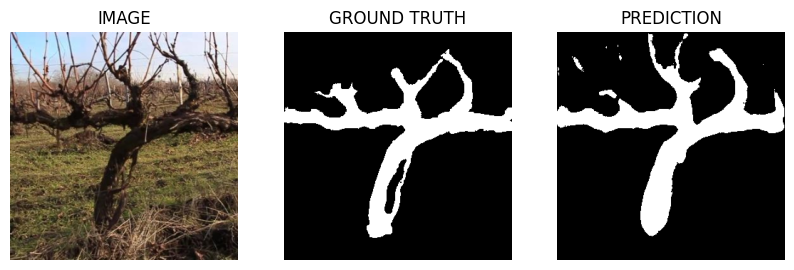

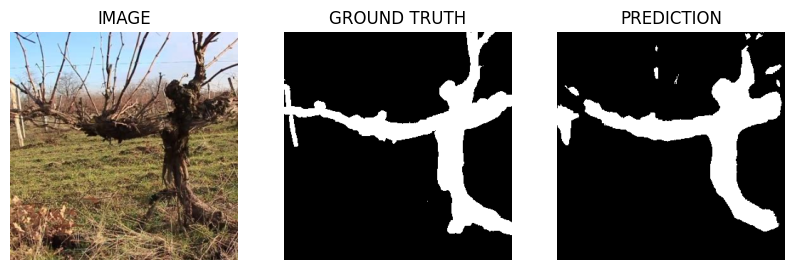

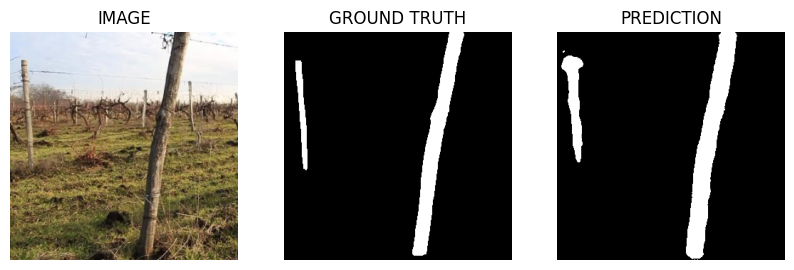

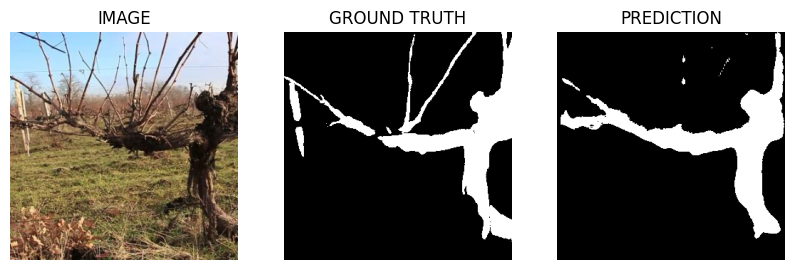

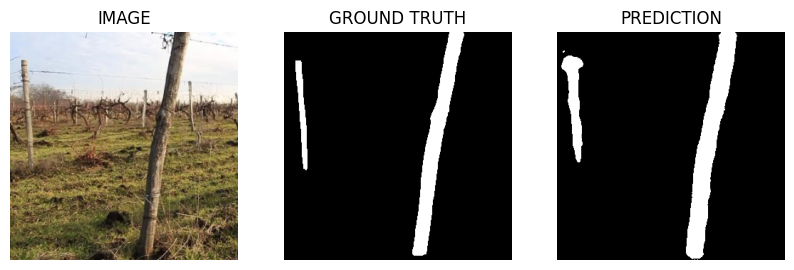

In [ ]:
# Compare predictions with original
for i in np.random.randint(0, len(val_data), 5):
    image, mask, pred_mask = make_inference(i)

    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

The model performs fairly decent but there is still room for improvement. To further improve the performance the below mentioned steps can be

**Steps to improve the model performance:**
- Try running the model for more epochs
- Try using different model architectures
- Try using different encoder models
- Try using more efficient methods such as early stopping to prevent overfitting
- Try using differnt learning rate schedulers to reduce learning rate near convergence region.

**Consider giving an upvote👍 if you liked the notebook. It will help it to reach a wider audience.**

**It would be highly appreciated if you can take out some time to share your views on what you liked in the notebook and what can be the potential improvements that can be made to further improve the notebook.**

**Thanks**

# References

- **Notebook inspired from this project**: https://www.coursera.org/projects/deep-learning-with-pytorch-image-segmentation
- **Image Segmentation**: https://www.ibm.com/topics/image-segmentation
- **albumentations documentation**: https://albumentations.ai/docs/
- **segmentation_models_pytorch documentation**: https://smp.readthedocs.io/en/latest/
- **Unet++ original paper**: https://arxiv.org/abs/1807.10165
- **Dice Loss**: https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.

In [ ]:
torch.cuda.empty_cache()